**Learning distribution with Neural Spline Flow**

In [1]:
import jax
import jax.numpy as jnp
import haiku as hk
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from functools import partial

tfd = tfp.distributions
tfb = tfp.bijectors

In [221]:
class NeuralSplineCoupling(hk.Module):
    def __init__(self, nunits, nbins=32):
        super(NeuralSplineCoupling, self).__init__()
        self.nunits = nunits
        self.nbins = nbins
        
    def bin_positions(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins])
        return jax.nn.softmax(x, axis=-1) *  (2. - self.nbins * 1e-2) + 1e-2
  
    def slopes(self, x):
        x = jnp.reshape(x, [-1, self.nunits, self.nbins - 1])
        return jax.nn.softplus(x) + 1e-2
    
    def __call__(self, x):
        net = jax.nn.leaky_relu(hk.Linear(128)(x))
        net = jax.nn.leaky_relu(hk.Linear(128)(net))

        bin_widths = self.bin_positions(hk.Linear(self.nunits*self.nbins)(net))
        bin_heights = self.bin_positions(hk.Linear(self.nunits*self.nbins)(net))
        knot_slopes = self.slopes(hk.Linear(self.nunits*(self.nbins-1))(net))

        return tfb.RationalQuadraticSpline(
                bin_widths=bin_widths,
                bin_heights=bin_heights,
                knot_slopes=knot_slopes)

In [256]:
def forward(x, nunits):
    model = NeuralSplineCoupling(nunits)
    return model(x)

In [223]:
forward = hk.transform(forward, apply_rng=True)

In [224]:
d = 2
x = jnp.zeros((1, d//2))
key = hk.PRNGSequence(42)
params = forward.init(next(key), x, 1)

In [225]:
spline1 = partial(forward.apply, params, None)

In [226]:
from real_nvp import RealNVP

In [227]:
nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=RealNVP(1, bijector_fn=spline1),
                event_shape=(d,))

In [228]:
samps = nvp.sample((1000,), seed=jax.random.PRNGKey(1))

Populating the interactive namespace from numpy and matplotlib


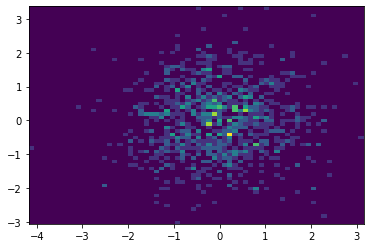

In [229]:
%pylab inline
hist2d(samps[:,0], samps[:,1],64);

In [252]:
class NeuralSplineFlow(hk.Module):
    def __init__(self):
        super(NeuralSplineFlow, self).__init__()
    
    def __call__(self, x):
        spline1 = NeuralSplineCoupling(1)
        spline2 = NeuralSplineCoupling(1)

        # Computes the likelihood of these x
        chain = tfb.Chain([
            tfb.Scale(10),
            RealNVP(1, bijector_fn=spline1),
            tfb.Permute([1,0]),
            RealNVP(1, bijector_fn=spline2),
            tfb.Permute([1,0]),
            tfb.Scale(0.1)
        ])

        nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(2,))

        return nvp.log_prob(x)

In [253]:
def forward2(x):
    flow = NeuralSplineFlow()
    return flow(x)
             
forward2 = hk.transform(forward2, apply_rng=True)

In [254]:
x = jnp.zeros((1, 2))
key = hk.PRNGSequence(3)
params = forward2.init(next(key), x)

TypeError: __call__() takes 2 positional arguments but 3 were given